In [53]:
import matplotlib.pyplot as plt
import cv2
import sklearn
import mediapipe as mp
import os
import time
import numpy as np

## Keypoints using MP Holistics

In [54]:
mp_holistic = mp.solutions.holistic
mp_drawing =mp.solutions.drawing_utils

In [55]:
def mediapipe_detections(image, model):
    image =cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #color conversion
    image.flags.writeable=False                  #image is no longer writable
    results = model.process(image)                # make detections
    image.flags.writeable=True                   #image is writable now
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # color conversion
    return image , results

In [56]:
def draw_landmarks(image , results):
    mp_drawing.draw_landmarks(image , results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                             mp_drawing.DrawingSpec(color=(0,0,255),thickness=1,circle_radius=1),
                             mp_drawing.DrawingSpec(thickness=1,circle_radius=1))
    mp_drawing.draw_landmarks(image , results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(thickness=2,color=4),mp_drawing.DrawingSpec(thickness=2,circle_radius=2)),
    mp_drawing.draw_landmarks(image , results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(thickness=2,color=4),mp_drawing.DrawingSpec(thickness=2,circle_radius=2)),
    mp_drawing.draw_landmarks(image , results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(thickness=2,color=4),mp_drawing.DrawingSpec(thickness=2,circle_radius=2))

In [57]:
cap = cv2.VideoCapture(0)
#set mediapipe holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5 ,min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
    
        #Make detections
        image , results = mediapipe_detections(frame , holistic)

        #rendering results
        draw_landmarks(image ,results)
        
        # Display the captured frame
        cv2.imshow('Video', image)  
        if cv2.waitKey(1) == 27:
            break  
cap.release()
cv2.destroyAllWindows()




In [58]:
len(results.left_hand_landmarks.landmark)

AttributeError: 'NoneType' object has no attribute 'landmark'

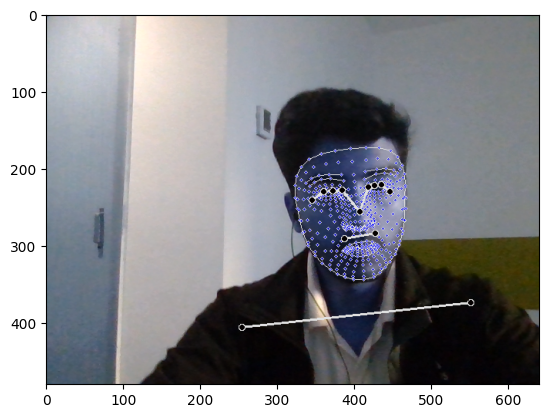

In [59]:
plt.imshow(image)

## Extract keypoint values

In [27]:
pose =np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)

In [28]:
lh = np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten()if results.left_hand_landmarks else np.zeros(21*3)

In [29]:
rh =np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)


In [39]:
face = np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)

In [41]:
face.shape

(1404,)

In [60]:
def extract_keypoints(results):
    pose =np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    lh = np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten()if results.left_hand_landmarks else np.zeros(21*3)
    rh =np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    face = np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    return np.concatenate([pose , face, lh,rh])

In [61]:
extract_keypoints(results).shape

(1662,)

## Set up Folders for Data Collections

In [149]:
#path for the exported data to be stored
Data_path = os.path.join('mp_data')

#Actions that we going to detect
actions = np.array(["Hello","Thank you", "ILoveU"])

#30 videos worth of data 
no_sequences = 30

#videos are going to be 30 frames in length 
sequence_length =30

In [150]:
for action in actions :
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(Data_path , action,action+str(sequence)))
        except:
            pass
        

## Collect keypoints for training and testing 

In [153]:
cap = cv2.VideoCapture(0)
#set mediapipe holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5 ,min_tracking_confidence=0.5) as holistic:
    # Loop through the actions
    for action in ["ILoveU"]:
        # Loop through the sequences aka videos 
        for sequence in range (no_sequences):
            # loop throgh the frames 
            for frame_num in range(sequence_length):
                ret, frame = cap.read()
                
                #Make detections
                image , results = mediapipe_detections(frame , holistic)
        
                #rendering results
                draw_landmarks(image ,results)

                # Apply wait logic
                if frame_num==0:
                    cv2.putText(image , "Starting Collection",(120,200),cv2.FONT_HERSHEY_COMPLEX,1,(0,255,0),4,cv2.LINE_AA)
                    cv2.waitKey(2000)
                    cv2.putText(image , "frames {} Video {}".format(action,sequence),(15,20),cv2.FONT_HERSHEY_COMPLEX,1,(0,0,255),1,cv2.LINE_AA)
                    cv2.waitKey(2000)
                else:
                     cv2.putText(image , "frames {} Video {}".format(action,sequence),(15,20),cv2.FONT_HERSHEY_COMPLEX,1,(0,0,255),1,cv2.LINE_AA)

                #save the keypoints 
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(Data_path , action,action+str(sequence),str(frame_num))
                np.save(npy_path,keypoints)
                # Display the captured frame
                cv2.imshow('Video', image)  
                if cv2.waitKey(1) == 27:
                    break
    cap.release()
    cv2.destroyAllWindows()




In [49]:
cap.release()
cv2.destroyAllWindows()

## Preorocess the Data and Create Features and Labels

In [154]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [155]:
label_map = {label:num for num , label in enumerate(actions)}
label_map

{'Hello': 0, 'Thank you': 1, 'ILoveU': 2}

In [156]:
sequences , labels =[],[]
for action in actions:
    for sequence in range(no_sequences):
        window=[]
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(Data_path,action,action+str(sequence),'{}.npy'.format(sequence)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [157]:
len(sequences[0][0])

1662

In [158]:
np.array(sequences).shape

(90, 30, 1662)

In [159]:
np.array(labels).shape

(90,)

In [160]:
X= np.array(sequences)
X.shape

(90, 30, 1662)

In [161]:
# we have 3 signs so far mapped to 0 ,1, 2 in label_map so this code will convert these 3 categories into one hot vectors
y=to_categorical(labels).astype(int)
y.shape

(90, 3)

In [162]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [163]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.05,random_state=0)

In [164]:
X_train.shape

(85, 30, 1662)

In [165]:
X_test.shape

(5, 30, 1662)

## Build and train the LSTM Model

In [166]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.callbacks import TensorBoard

In [167]:
logs_dir = os.path.join("Logs")
tb_callbacks = TensorBoard(log_dir=logs_dir)

In [168]:
model =Sequential()
model.add(LSTM(64,return_sequences =True , input_shape =(30,1662),activation="relu"))
model.add(LSTM(128,return_sequences =True ,activation="relu"))
model.add(LSTM(64,return_sequences =False ,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(actions.shape[0],activation="softmax"))

In [169]:
actions.shape[0]

3

In [170]:
from tensorflow.keras.callbacks import EarlyStopping

# Assuming you have defined your model and loaded your data
# Split your data into training and validation sets

# Define early stopping callback
early_stopping = EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)

# Compile your model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])



In [171]:
# Train the model with early stopping using only training data
history = model.fit(X_train, y_train, epochs=2000, callbacks=[early_stopping])

Epoch 1/2000
3/3 [==============================] - 3s 86ms/step - loss: 2.4828 - categorical_accuracy: 0.2706
Epoch 2/2000
3/3 [==============================] - 0s 70ms/step - loss: 10.5000 - categorical_accuracy: 0.3294
Epoch 3/2000
3/3 [==============================] - 0s 68ms/step - loss: 19.7649 - categorical_accuracy: 0.3176
Epoch 4/2000
3/3 [==============================] - 0s 67ms/step - loss: 5.1381 - categorical_accuracy: 0.3882
Epoch 5/2000
3/3 [==============================] - 0s 68ms/step - loss: 6.3524 - categorical_accuracy: 0.3294
Epoch 6/2000
3/3 [==============================] - 0s 66ms/step - loss: 38.3413 - categorical_accuracy: 0.3176
Epoch 7/2000
3/3 [==============================] - 0s 67ms/step - loss: 66.1377 - categorical_accuracy: 0.3647
Epoch 8/2000
3/3 [==============================] - 0s 67ms/step - loss: 31.0961 - categorical_accuracy: 0.3765
Epoch 9/2000
3/3 [==============================] - 0s 68ms/step - loss: 18.3376 - categorical_accuracy: 0.

In [172]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 30, 64)            442112    
                                                                 
 lstm_11 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_12 (LSTM)              (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596675 (2.28 MB)
Trainable params: 59667

## Make Predictions

In [173]:
y_pred =model.predict(X_test)

1/1 [==============================] - 0s 254ms/step


In [174]:
for i in range(len(y_pred)):
    print(actions[np.argmax(y_pred[i])])

Hello
Hello
Thank you
Thank you
ILoveU


## Save Weights

In [175]:
model.save('action.h5')

C:\Users\adars\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [176]:
model.load_weights('action.h5')

In [177]:
model

## Evaluation using Confusion_Matrix and Accuracy

In [178]:
from sklearn.metrics import multilabel_confusion_matrix,accuracy_score

In [179]:
ypred = model.predict(X_test)

1/1 [==============================] - 0s 22ms/step


In [180]:
y_true = np.argmax(y_test,axis=1).tolist()
ypred = np.argmax(ypred,axis=1).tolist()


In [181]:
y_true

[0, 0, 1, 1, 2]

In [182]:
ypred

[0, 0, 1, 1, 2]

In [183]:
multilabel_confusion_matrix(y_true,ypred)

array([[[3, 0],
        [0, 2]],

       [[3, 0],
        [0, 2]],

       [[4, 0],
        [0, 1]]], dtype=int64)

In [184]:
accuracy_score(y_true,ypred)

1.0

In [208]:
colors=[(245,117,16),(117,245,16),(16,117,245)]
def prob_viz(res,input_frame , actions, colors):
    output_frame = input_frame.copy()
    for num , prob in enumerate(res):
        # cv2.rectangle(image, start_point, end_point, color, thickness)
        cv2.rectangle(output_frame, (0,60+num*40),(int(prob*100),90+num*40),colors[num],-1)
        cv2.putText(output_frame ,actions[num],(0,85+num*40),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)
    return output_frame 

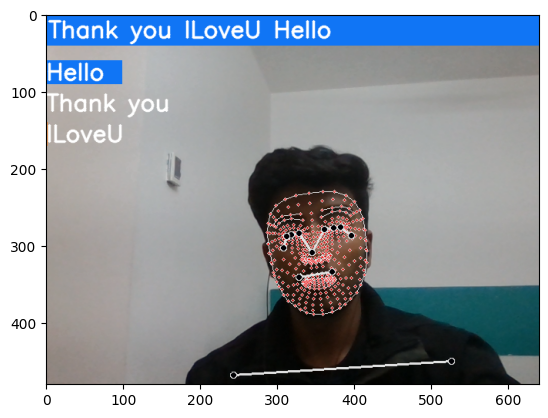

In [211]:
plt.imshow (cv2.cvtColor(prob_viz(res,image,actions,colors) , cv2.COLOR_RGB2BGR))

In [220]:
#1.Set new Detection variables
sequence=[]
sentence=[]
predictions=[]
threshold=0.7

cap = cv2.VideoCapture(0)
#set mediapipe holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5 ,min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
    
        #Make detections
        image , results = mediapipe_detections(frame , holistic)

        #rendering results
        draw_landmarks(image ,results)

        #2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        if(len(sequence)==30):
            res= model.predict(np.expand_dims(sequence,axis=0))[0]
            predictions.append(np.argmax(res))
            # print(actions[np.argmax(res)])
        
            # 3. Visualisation Logic
            if(np.unique(predictions[-10:])[0] == np.argmax(res)):
                if res[np.argmax(res)]>threshold:  #if the threshold or the prob is greater than the threshold only then we will append the result
                    if len(sentence)>0:  #if the sentence array already has some words then 
                        if actions[np.argmax(res)] !=sentence[-1]:  #ensure that the latest prediction for the action doesnot match the previous action 
                            sentence.append(actions[np.argmax(res)])  #if it doesnot then it means that we have a different action so we append it 
                    else : 
                        # if the sentence array is empty then we append the latest sign predicted
                        sentence.append(actions[np.argmax(res)])
            if len(sentence)>5:
                # this is to ensure we dont keep on holding on the the previous actions 
                sentence=sentence[-3:]
    
            image = prob_viz(res,image,actions,colors)
        cv2.rectangle(image, (0,0) , (640,40) , (245,117,16),-1)
        cv2.putText(image,' '.join(sentence),(3,30),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)
        
        
        # Display the captured frame
        cv2.imshow('Video', image)  
        if cv2.waitKey(1) == 27:
            break  
    cap.release()
    cv2.destroyAllWindows()




1/1 [==============================] - 0s 18ms/step


In [217]:
cap.release()
cv2.destroyAllWindows()